In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
path =  '/Users/gokhanersoz/Desktop/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

f = open(file = path , mode = "r")
lines = f.readlines()

lines[0]

'33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;\n'

In [4]:
line = lines[0].split(",")
line

['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286;\n']

In [5]:
last = line[-1].split(";")[0]
last = last.strip()
last

'0.50395286'

In [6]:
processedList = []

for i,line in enumerate(lines):
    
    try:
        
        line = line.split(",")
        last = line[-1].split(";")[0]
        last = last.strip()
        if last == '':
            break;
        
        tmp = [line[0],line[1],line[2],line[3],line[4],last]
        processedList.append(tmp)
                
        
    except:
        
        print("Error at line number : ", i)

In [7]:
processedList[0]

['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286']

In [8]:
columns = ["id", "activity","time","X","Y","Z"]

data = pd.DataFrame(data = processedList, columns = columns)
print("DataFrame Shape : {}".format(data.shape))

DataFrame Shape : (281873, 6)


In [9]:
data["activity"].value_counts()

Walking       111638
Jogging       104583
Upstairs       28898
Downstairs     28600
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [10]:
len(lines),len(processedList)

(1098210, 281873)

## Balance This Data

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281873 entries, 0 to 281872
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        281873 non-null  object
 1   activity  281873 non-null  object
 2   time      281873 non-null  object
 3   X         281873 non-null  object
 4   Y         281873 non-null  object
 5   Z         281873 non-null  object
dtypes: object(6)
memory usage: 12.9+ MB


In [12]:
data["X"] = data["X"].astype("float")
data["Y"] = data["Y"].astype("float")
data["Z"] = data["Z"].astype("float")

In [13]:
def plot_axis(ax, x, y, title):
    
    ax.plot(x,y, "g")
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x) , max(x)])
    ax.grid(True)
    

def plot_activity(activity, data):
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3 , ncols = 1, figsize = (16,7), sharex = True)
    plot_axis(ax0, data["time"], data["X"], "X-Axis")
    plot_axis(ax1, data["time"], data["Y"], "Y-Axis")
    plot_axis(ax2, data["time"], data["Z"], "Z-Axis")
    plt.subplots_adjust(hspace=0.2, top = 0.9)
    fig.suptitle(activity)
    plt.show()

In [14]:
activities = data["activity"].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

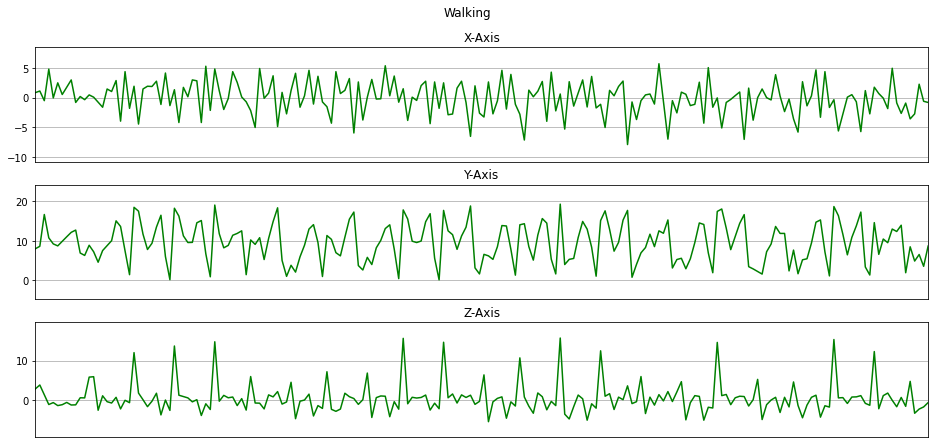

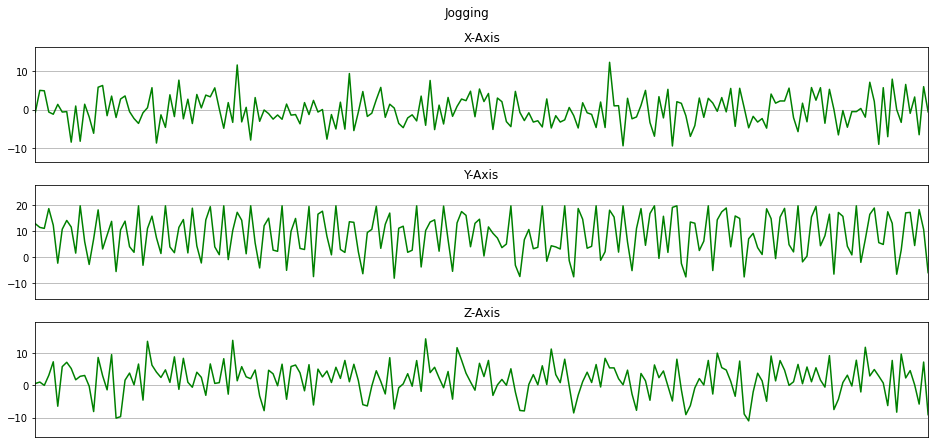

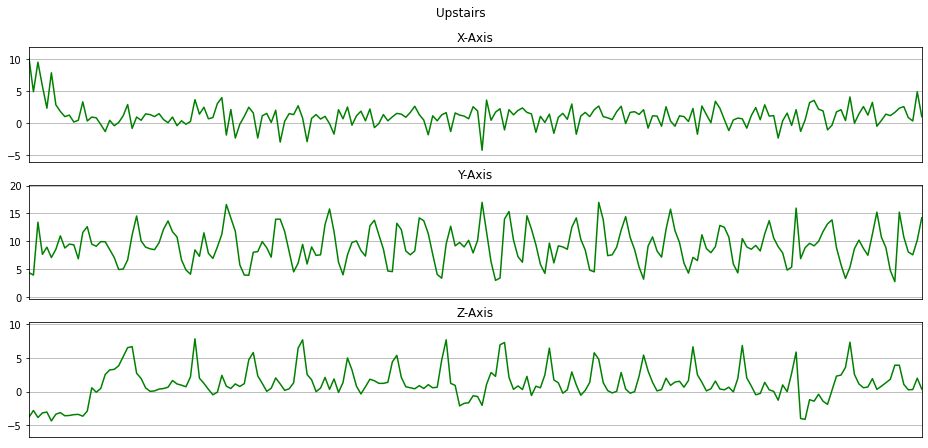

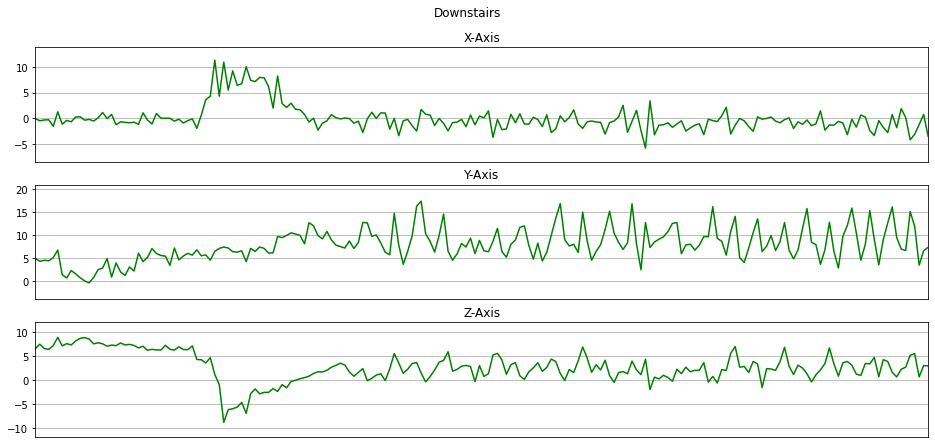

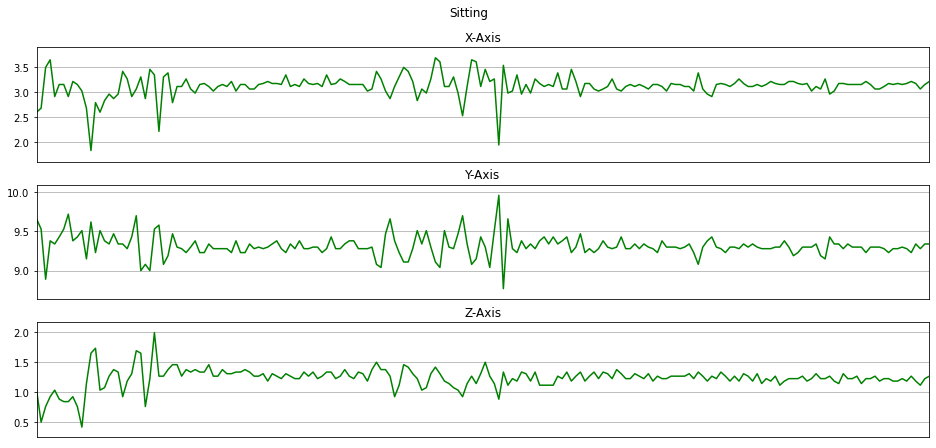

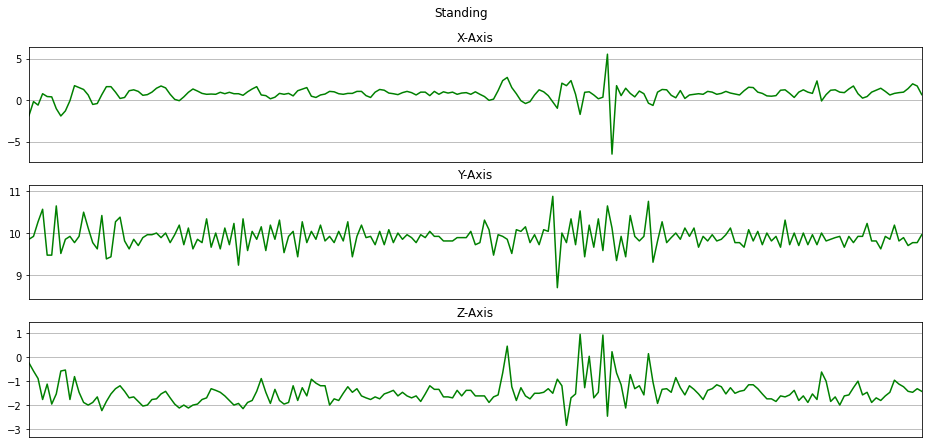

In [15]:
Fs = 20

for activity in activities:
    data_for_plot = data[(data["activity"] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [16]:
data["activity"].value_counts()

Walking       111638
Jogging       104583
Upstairs       28898
Downstairs     28600
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [17]:
Walking = data[data["activity"] == "Walking"].head(3555).copy()
Jogging = data[data["activity"] == "Jogging"].head(3555).copy()
Upstairs = data[data["activity"] == "Upstairs"].head(3555).copy()
Downstairs = data[data["activity"] == "Downstairs"].head(3555).copy()
Sitting = data[data["activity"] == "Sitting"].head(3555).copy()
Standing = data[data["activity"] == "Standing"].head(3555).copy()

In [18]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking,Jogging,Upstairs,Downstairs,Sitting,Standing])
balanced_data.shape

(21330, 6)

In [19]:
balanced_data["activity"].value_counts()

Downstairs    3555
Upstairs      3555
Standing      3555
Sitting       3555
Jogging       3555
Walking       3555
Name: activity, dtype: int64

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
label = LabelEncoder()
balanced_data["label"] = label.fit_transform(balanced_data["activity"])
balanced_data = balanced_data.drop(["id","time"], axis=1)
balanced_data.head()

,activity,X,Y,Z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


## Standardized Data

In [22]:
X = balanced_data[["X","Y","Z"]]
y = balanced_data["label"]

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

Scaled_X = pd.DataFrame(data = X , columns = ["X","Y","Z"])
Scaled_X["label"] = y.values
Scaled_X.head()

,X,Y,Z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5


## Frame Preparation

In [24]:
import scipy.stats as stats

In [25]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

dataframe = Scaled_X

In [26]:
def get_frames(dataframe , frame_size , hop_size ):
    
    N_FEATURES = 3
    
    frames = []
    labels = []
    
    for i in range(0, len(dataframe) - frame_size , hop_size):
        
        x = dataframe["X"].values[i : i + frame_size]
        y = dataframe["Y"].values[i : i + frame_size]
        z = dataframe["Z"].values[i : i + frame_size]
        
        label = stats.mode(dataframe["label"][i : i + frame_size])[0][0]
        # Burda np.array(frames).shape -- > (3,number) gibi değer çıkmakta 
        # Bizdeki asıl dataframe böyle değil
        
        frames.append([x,y,z])
        labels.append(label)
        
    # Burda ise shape olarak (number, 3 ) feature olarak çeviriyoruz !!!
    
    frames = np.asarray(frames).reshape(-1,frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels

In [27]:
X, y = get_frames(Scaled_X, frame_size, hop_size)

In [28]:
X.shape,y.shape

((532, 80, 3), (532,))

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=0, stratify = y)

In [30]:
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [32]:
# Biz bunu cnn göre yapmamız gerek !!!

X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80,3 , 1)

In [33]:
X_train.shape, X_test.shape

((425, 80, 3, 1), (107, 80, 3, 1))

## 2D CNN Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dropout,Dense
from tensorflow.keras.optimizers import Adam

In [39]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (2,2), activation = "relu", input_shape = (80,3,1)))
model.add(Dropout(rate = 0.1))
          
model.add(Conv2D(filters = 32, kernel_size = (2,2), activation = "relu", input_shape = (80,3,1)))
model.add(Dropout(rate = 0.2))
          
model.add(Flatten())
          
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(rate = 0.5))
          
model.add(Dense(units = 6, activation = "softmax"))
          
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 79, 2, 16)         80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 78, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2496)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                159808    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

In [41]:
model.compile(optimizer = Adam(learning_rate=0.001), loss = "sparse_categorical_crossentropy", 
             metrics = ["accuracy"])

history = model.fit(X_train, y_train, epochs = 10, validation_data =(X_test , y_test))

Train on 425 samples, validate on 107 samples
Epoch 1/10
425/425 [==============================] - 1s 3ms/sample - loss: 1.6232 - accuracy: 0.2565 - val_loss: 1.3636 - val_accuracy: 0.3084
Epoch 2/10
425/425 [==============================] - 0s 847us/sample - loss: 1.2820 - accuracy: 0.4988 - val_loss: 1.0429 - val_accuracy: 0.7570
Epoch 3/10
425/425 [==============================] - 0s 849us/sample - loss: 0.9665 - accuracy: 0.6682 - val_loss: 0.6719 - val_accuracy: 0.8972
Epoch 4/10
425/425 [==============================] - 0s 868us/sample - loss: 0.7219 - accuracy: 0.7388 - val_loss: 0.4856 - val_accuracy: 0.8505
Epoch 5/10
425/425 [==============================] - 0s 846us/sample - loss: 0.5464 - accuracy: 0.8165 - val_loss: 0.3651 - val_accuracy: 0.9065
Epoch 6/10
425/425 [==============================] - 0s 809us/sample - loss: 0.4031 - accuracy: 0.8824 - val_loss: 0.2900 - val_accuracy: 0.8972
Epoch 7/10
425/425 [==============================] - 0s 913us/sample - loss: 0.

In [42]:
def history_graph(history, epochs ):

    plt.figure(figsize = (15,6))
    size = 15
    plt.subplot(1,2,1)
    plt.plot(range(1,epochs+1), history.history["accuracy"], label = "Train")
    plt.plot(range(1,epochs+1),history.history["val_accuracy"], label = "Test")
    plt.legend(loc = "best")
    plt.title("Accuracy Graph", fontsize = size)
    plt.xlabel("Epochs", fontsize = size)
    plt.ylabel("Accuracy Score", fontsize = size)

    plt.subplot(1,2,2)
    plt.plot(range(1,epochs+1),history.history["loss"],label = "Train")
    plt.plot(range(1,epochs+1),history.history["val_loss"], label = "Test")
    plt.legend(loc = "best")
    plt.title("Loss Graph", fontsize = size)
    plt.xlabel("Epochs", fontsize = size)
    plt.ylabel("Loss Score", fontsize = size)

    plt.tight_layout()
    plt.show()

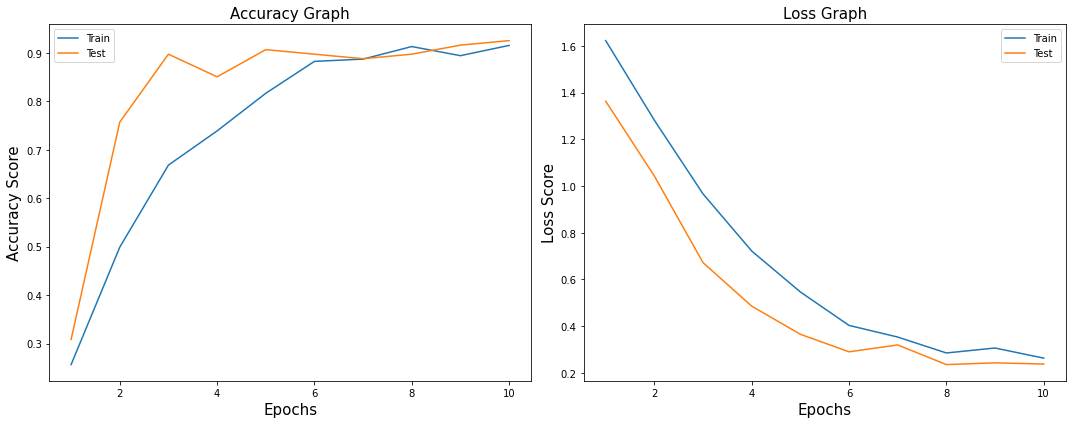

In [44]:
history_graph(history, 10)

In [45]:
def confusion_graph(y_true, y_pred, classes = "auto"):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (15,6))
    sns.heatmap(cm, annot = True, cbar = False, cmap = "viridis", annot_kws= {"size" : 15}, fmt = "d", xticklabels=classes , yticklabels = classes )
    
    size = 15
    plt.xlabel("Predicted",fontsize = size)
    plt.ylabel("Actual", fontsize = size)
    plt.title("Confusion Matrix" , fontsize = size)

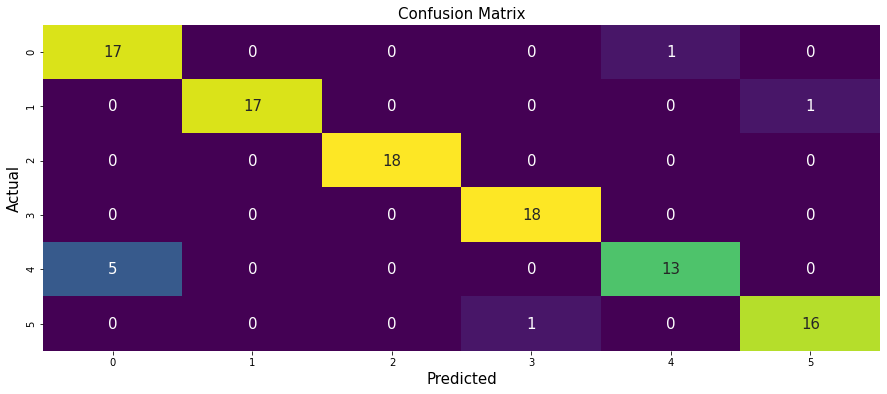

In [46]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]


confusion_graph(y_test, y_pred)